## Context

This notebook was developed as part of PHY 763 (Quantum Computing Laboratory).
The goal is to analyze experimental qubit readout data and extract physically
meaningful quantities from noisy measurements.

The emphasis is on physical interpretation and data analysis rather than
software engineering.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qm import SimulationConfig
from qm.qua import *
import os
import xarray as xr
import json
from quam_libs.components import QuAM
from quam_libs.lib.save_utils import find_numbered_folder
from scipy.optimize import curve_fit
from qualang_tools.analysis.discriminator import two_state_discriminator

2025-12-30 14:24:04,934 - qm - INFO     - Starting session: 32b71022-1bda-4a6e-b9ae-0cbe2f7ebff7


/Users/chuma_navarro/Projects/qolab-start/.venv/lib/python3.12/site-packages/qm/results/__init__.py:15: DeprecationWarning: qm.results is deprecated since "1.2.3" and will be removed in "1.3.0". If you need anything from this module, import it directly from `qm` or from `qm.simulate` for simulator-related functionality.
  warnings.warn(


In [2]:
def load_dataset(serial_number, target_filename = "ds", parameters = None):
    """
    Loads a dataset from a file based on the serial number.
    
    Args:
        serial_number: The serial number to search for.
        base_folder: The base directory to search in.
    
    Returns:
        An xarray Dataset if found, None otherwise.
    """
    if not isinstance(serial_number, int):
        raise ValueError("serial_number must be an integer")
        
    base_folder = find_numbered_folder("data",serial_number)
    # Look for .nc files in the subfolder
    nc_files = [f for f in os.listdir(base_folder) if f.endswith('.h5')]
    
    # look for filename.h5
    is_present = target_filename in [file.split('.')[0] for file in nc_files]
    filename = [file for file in nc_files if target_filename == file.split('.')[0]][0] if is_present else None
    json_filename = "data.json"
    
    if nc_files:
        # Assuming there's only one .nc file per folder
        file_path = os.path.join(base_folder, filename)
        json_path = os.path.join(base_folder, json_filename)
        # Open the dataset
        ds = xr.open_dataset(file_path)
        with open(json_path, 'r') as f:
            json_data = json.load(f)
        try:
            machine = QuAM.load(base_folder + "/quam_state/state.json")
        except Exception as e:
            print(f"Error loading machine: {e}")
            machine = None
        qubits = [machine.qubits[qname] for qname in ds.qubit.values]    
        if parameters is not None:
            for param_name, param_value in parameters:
                if param_name != "load_data_id":
                    if param_name in json_data["initial_parameters"]:
                        setattr(parameters, param_name, json_data["initial_parameters"][param_name])
            return ds, machine, json_data, qubits,parameters
        else:
            return ds, machine, json_data, qubits
    else:
        print(f"No .nc file found in folder: {base_folder}")
        return None


# Load Old Data
To load old data, we use the `load_dataset` command with the serial number of the dataset. The serial number is the number of the experiment in the `data` tab of the `qualibrate` dashboard; also, it is the numbers coming directly after the `#` in the `data` sub-folders.

Here are the relevant experiments we will look at in this assignment:
- 65: Experiment number 65 was the 'bad' data we took in class for IQ Blobs on 2025-10-13;
- 71: Experiment number 71 was the 'good' data I showed in class for IQ Blobs (taken on 2025-10-14); 
- 58: Experiment number 58 was the 'bad' data we took in class for T1 on 2025-10-13; 
- 70: Experiment number 70 was the 'good' data I showed in class for T1 (taken on 2025-10-14).

Other experiments are provided in the data folder for you to peruse. The qolab-start provided data analysis can be applied to old data, even without a token, by navigating to the associated node in node library and putting in the data ID in the `Load Data ID` field. For example, experiment 54 was qubit spectroscopy (see `data/2025-10-13/#54_03a_Qubit_Spectroscopy_153559/`). Navigating to the node library, node `03a_Qubit_Spectroscopy` and putting in experiment 54 into `Load Data ID` will allow you to run the analysis on the old data (reproducing the plot that is already in the data tab for experiment 54). This will be useful when we make new nodes that operate on the same experimental data. Note that all of the nodes are defined in `code/calibration_graph/`. New nodes can be added here; old nodes can adjusted. It can also be helpful to look there to see how the fits are currently done. This might help you with the below assignment.

I provide two example dataset loading and plotting to help for the problems.

In [3]:
b = load_dataset(65)

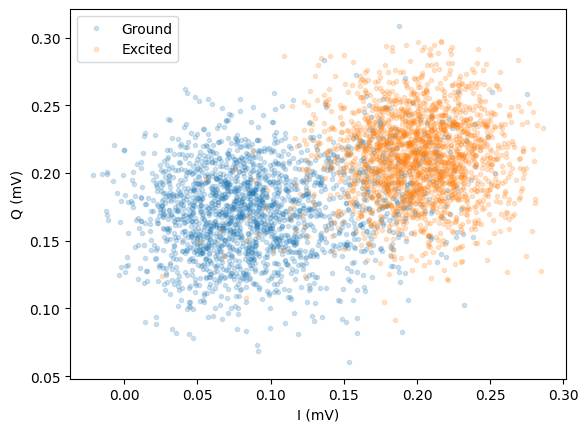

In [4]:
plt.plot(1e3*b[0].I_g.sel(qubit="q2").values,1e3*b[0].Q_g.sel(qubit="q2"),".",alpha=0.2,label="Ground")
plt.plot(1e3*b[0].I_e.sel(qubit="q2").values,1e3*b[0].Q_e.sel(qubit="q2"),".",alpha=0.2,label="Excited")
plt.xlabel("I (mV)")
plt.ylabel("Q (mV)")
plt.legend()

In [5]:
a = load_dataset(70)

The data is in a `xarray`, which has a lot of nifty features. For now, we can access the raw data via directly accessing the `values`. 

In [6]:
print("Qubit 2's averaged populations.")
#Note that qubit 2 is index 1!
print(a[0]['state'].values[1])

Qubit 2's averaged populations.
[0.994 0.952 0.924 0.87  0.87  0.854 0.81  0.78  0.744 0.712 0.628 0.676
 0.624 0.616 0.598 0.558 0.512 0.512 0.496 0.486 0.446 0.386 0.398 0.384
 0.354 0.372 0.368 0.358 0.34  0.286 0.274 0.256 0.236 0.232 0.23  0.242
 0.254 0.206 0.18  0.216 0.222 0.202 0.164 0.13  0.17  0.174 0.17  0.14
 0.17  0.138 0.126 0.102 0.132 0.128 0.118 0.126 0.116 0.088 0.106 0.126
 0.082 0.086 0.086 0.09  0.098 0.074 0.1   0.088 0.08  0.086 0.072 0.074
 0.066 0.084 0.112 0.076 0.076 0.088 0.08  0.076]


We can plot the data versus time for qubit 2 using

Text(0, 0.5, 'State')

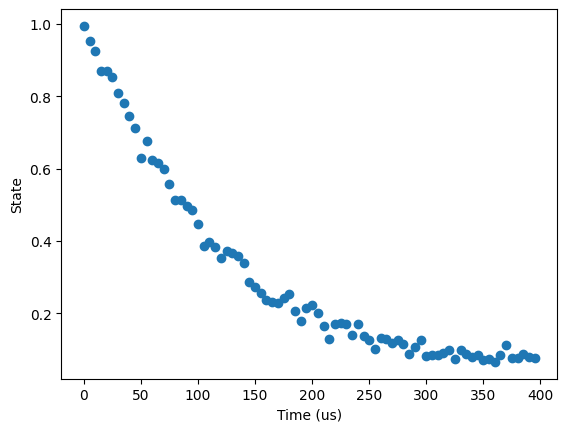

In [7]:
plt.clf()
plt.plot(a[0]["idle_time"],a[0]['state'].values[1],"o")
plt.xlabel("Time (us)")
plt.ylabel("State")

## Problem #2
Plot the data for the IQ Blobs experiments in datasets 65 and 71. Using `two_state_discriminator` (`from qualang_tools.analysis.discriminator import two_state_discriminator`) find a threshold between `0` and `1` and calculate the confusion matrix. Compare the confusion matrices from experiments 65 and 71. `code/calibration_graph/07c_IQ_Blobs.py` may be helpful here. Plot all IQ blobs and confusion matrices for both experiments. Which qubit, from any experiment, performs the best?


Exp 65 - q1: Fidelity = 50.8000
Confusion Matrix: [[0.496, 0.504], [0.480, 0.520]]
Exp 65 - q2: Fidelity = 90.9250
Confusion Matrix: [[0.859, 0.141], [0.040, 0.960]]
Exp 65 - q3: Fidelity = 92.2500
Confusion Matrix: [[0.933, 0.067], [0.088, 0.912]]
Exp 65 - q4: Fidelity = 87.5500
Confusion Matrix: [[0.941, 0.059], [0.190, 0.810]]
Exp 65 - q5: Fidelity = 90.7500
Confusion Matrix: [[0.941, 0.059], [0.126, 0.875]]
Exp 65 - q6: Fidelity = 97.0500
Confusion Matrix: [[0.962, 0.038], [0.021, 0.979]]


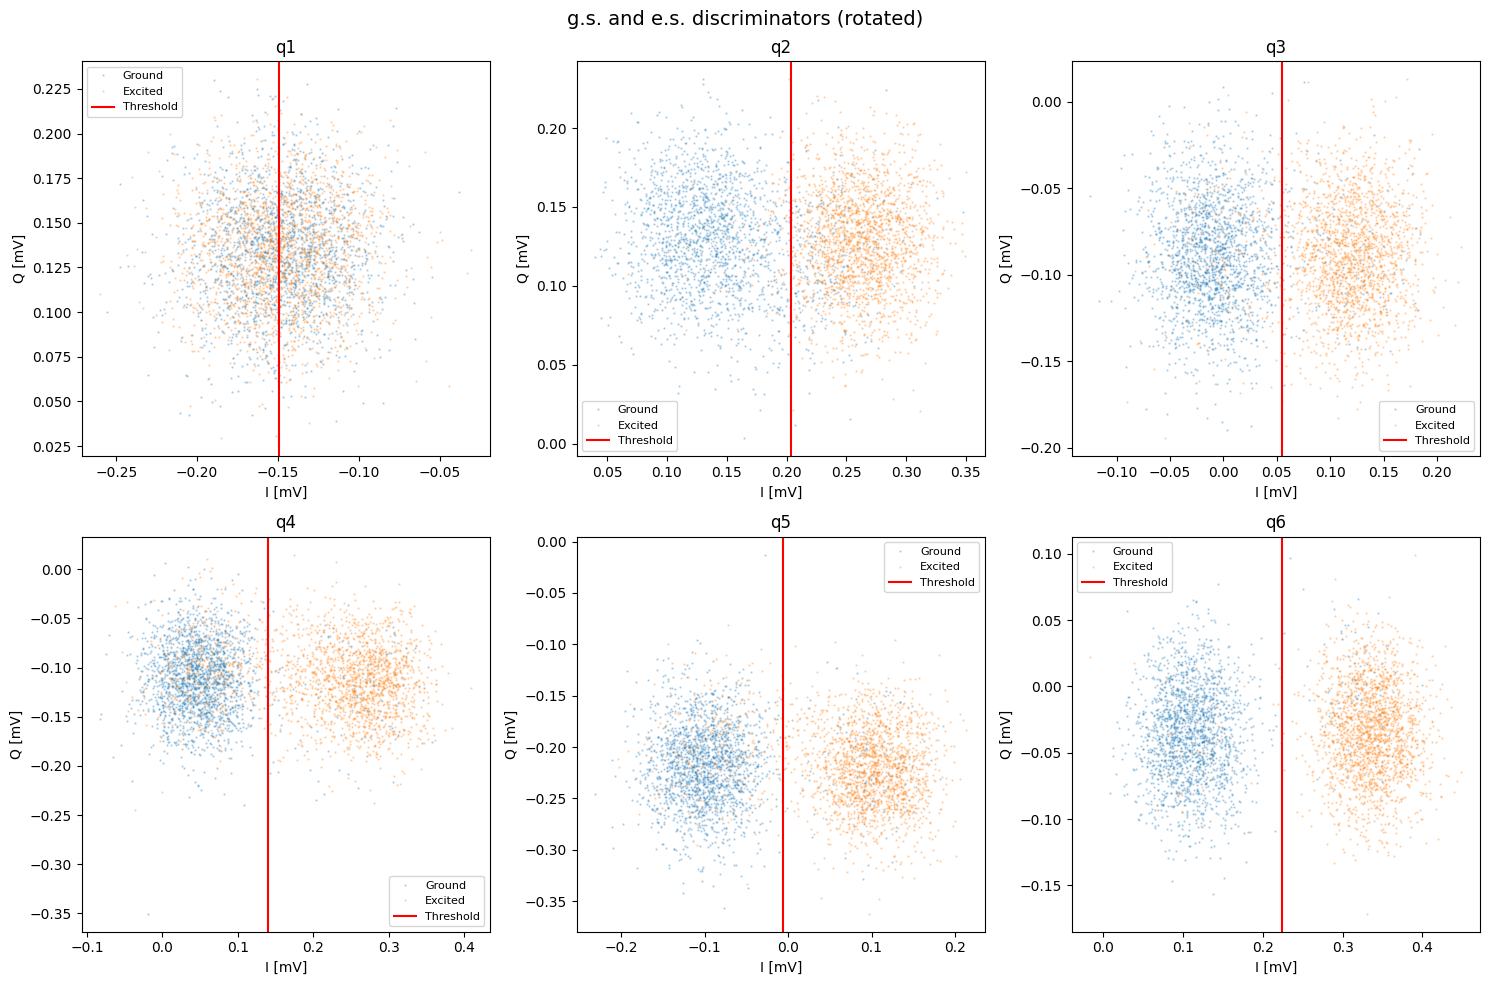

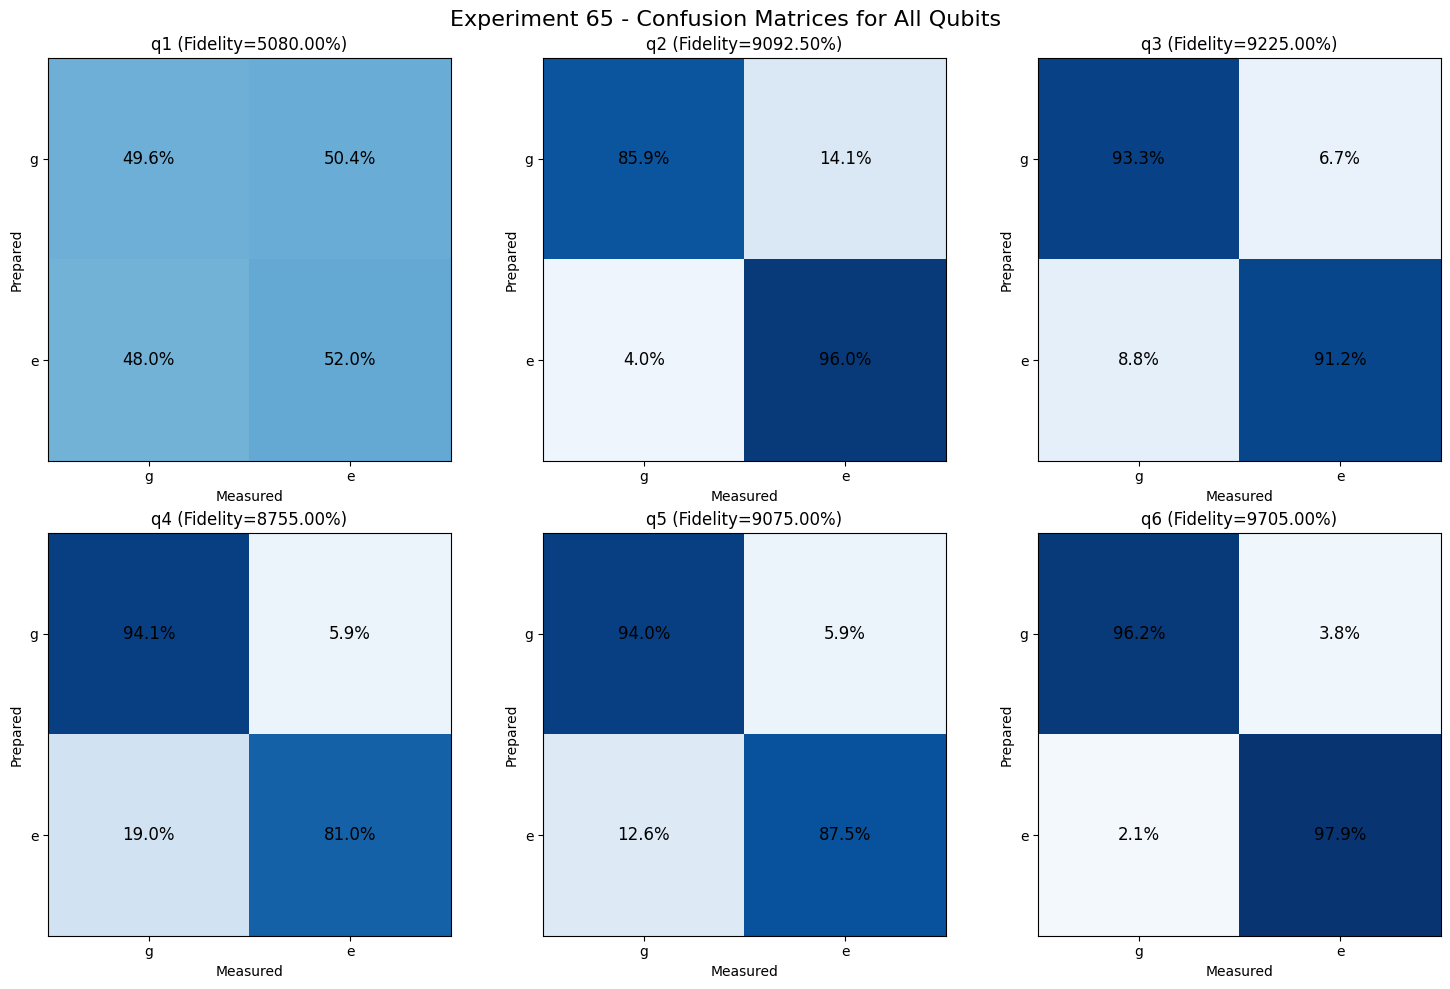



Exp 71 - q1: Fidelity = 50.3750
Confusion Matrix: [[0.533, 0.467], [0.526, 0.474]]
Exp 71 - q2: Fidelity = 96.8250
Confusion Matrix: [[0.958, 0.043], [0.021, 0.979]]
Exp 71 - q3: Fidelity = 86.9750
Confusion Matrix: [[0.824, 0.176], [0.084, 0.916]]
Exp 71 - q4: Fidelity = 93.3250
Confusion Matrix: [[0.944, 0.056], [0.077, 0.922]]
Exp 71 - q5: Fidelity = 88.9750
Confusion Matrix: [[0.901, 0.099], [0.121, 0.878]]
Exp 71 - q6: Fidelity = 97.1250
Confusion Matrix: [[0.961, 0.039], [0.018, 0.982]]


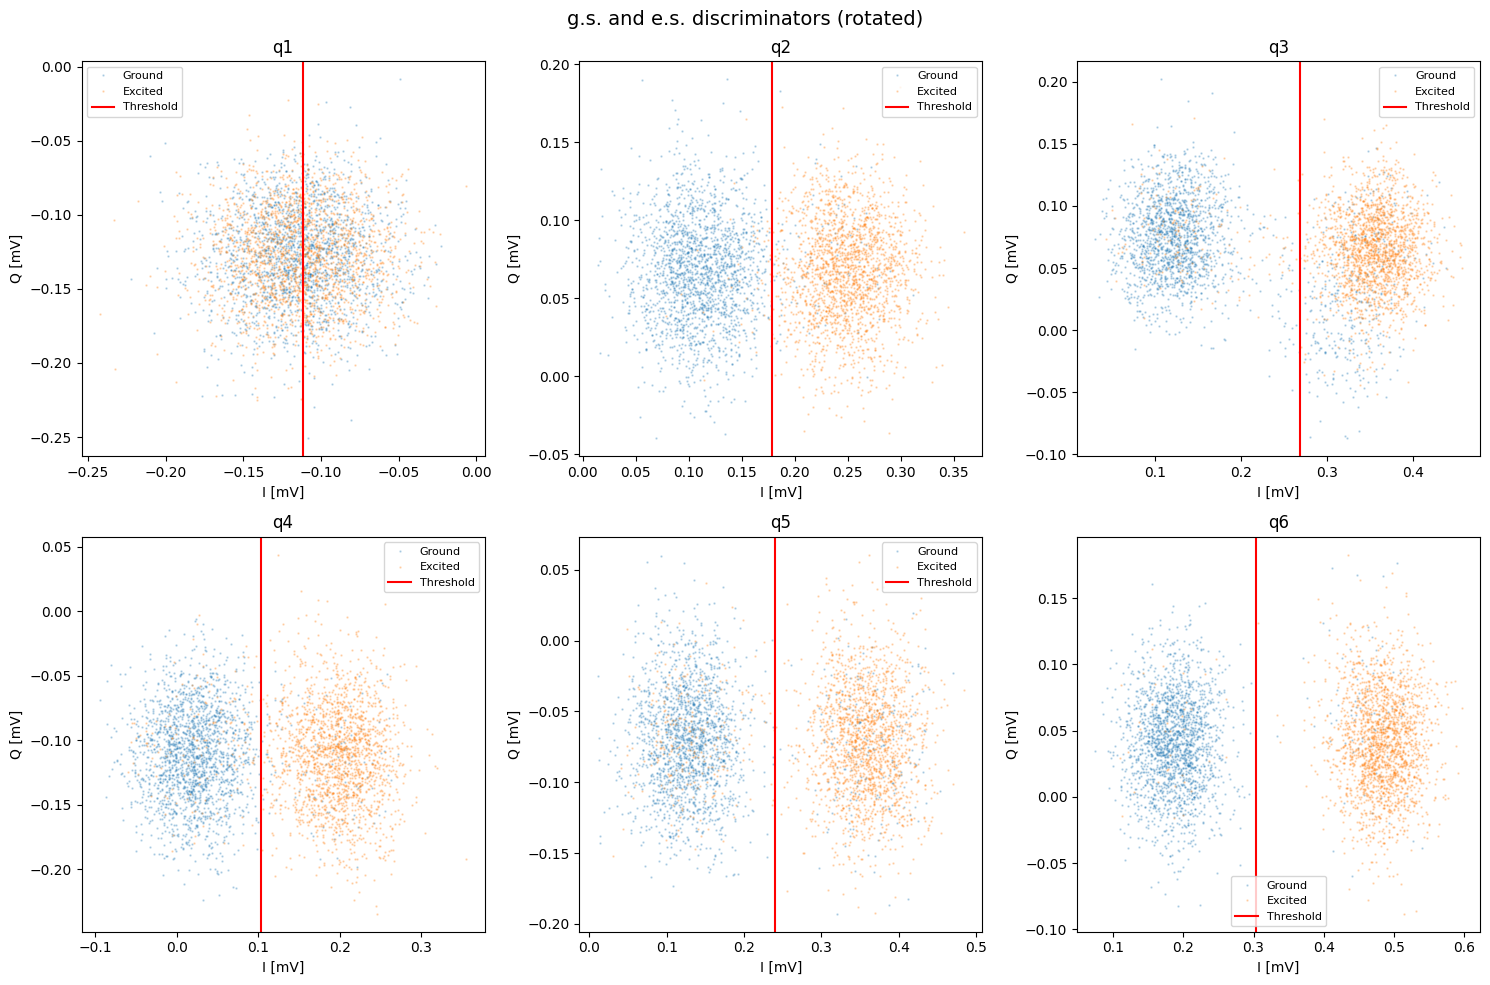

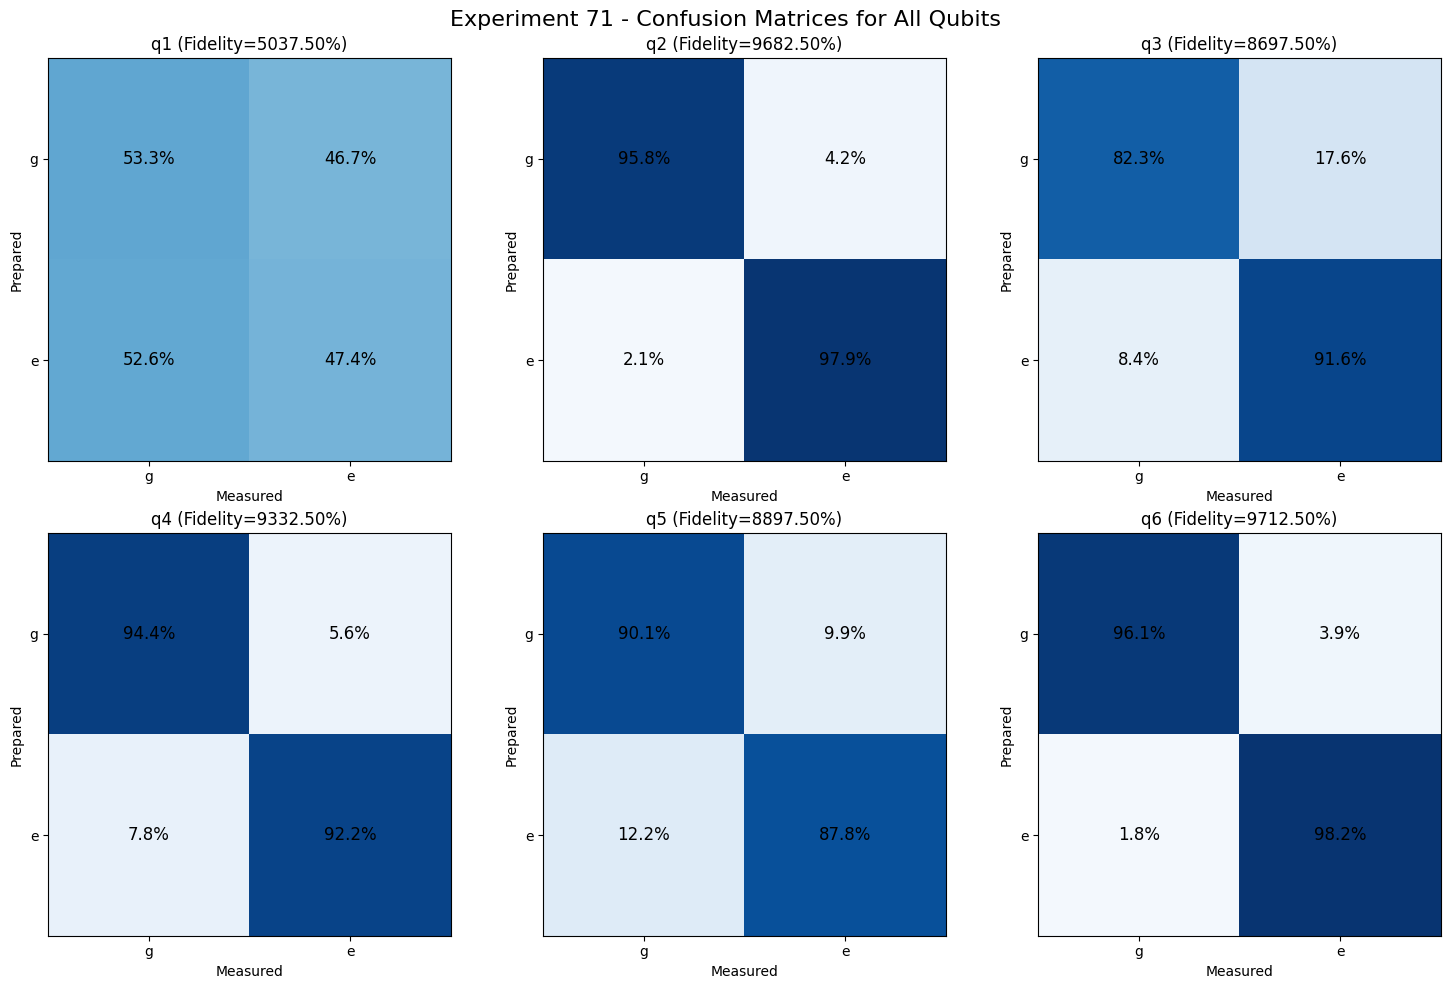



Best performing qubit: Exp71_q6 with fidelity 97.1250


In [8]:
# Load datasets
ds_65 = load_dataset(65)
ds_71 = load_dataset(71)

# Store results
results = {}

# Helper: choose rotation convention that places threshold between class means
def _choose_rotation(I_g, Q_g, I_e, Q_e, angle, threshold):
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    # Convention A: I_rot = I*cos + Q*sin; Q_rot = -I*sin + Q*cos
    I_g_A = I_g * cos_a + Q_g * sin_a
    Q_g_A = -I_g * sin_a + Q_g * cos_a
    I_e_A = I_e * cos_a + Q_e * sin_a
    Q_e_A = -I_e * sin_a + Q_e * cos_a
    mA_g = np.nanmean(I_g_A); mA_e = np.nanmean(I_e_A)
    betweenA = (min(mA_g, mA_e) <= threshold <= max(mA_g, mA_e))
    midA = 0.5 * (mA_g + mA_e)
    # Convention B: I_rot = I*cos - Q*sin; Q_rot = I*sin + Q*cos
    I_g_B = I_g * cos_a - Q_g * sin_a
    Q_g_B = I_g * sin_a + Q_g * cos_a
    I_e_B = I_e * cos_a - Q_e * sin_a
    Q_e_B = I_e * sin_a + Q_e * cos_a
    mB_g = np.nanmean(I_g_B); mB_e = np.nanmean(I_e_B)
    betweenB = (min(mB_g, mB_e) <= threshold <= max(mB_g, mB_e))
    midB = 0.5 * (mB_g + mB_e)
    if betweenA and not betweenB:
        return I_g_A, Q_g_A, I_e_A, Q_e_A
    if betweenB and not betweenA:
        return I_g_B, Q_g_B, I_e_B, Q_e_B
    return (I_g_A, Q_g_A, I_e_A, Q_e_A) if abs(threshold - midA) <= abs(threshold - midB) else (I_g_B, Q_g_B, I_e_B, Q_e_B)

# Analyze both experiments
for exp_num, ds in [(65, ds_65), (71, ds_71)]:
    qubits = ds[0].qubit.values

    # IQ blobs (2x3 subplots)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    confusion_matrices = []

    for idx, qubit in enumerate(qubits):
        # Use Volts for discriminator; convert to mV only for plotting
        I_g = ds[0].I_g.sel(qubit=qubit).values
        Q_g = ds[0].Q_g.sel(qubit=qubit).values
        I_e = ds[0].I_e.sel(qubit=qubit).values
        Q_e = ds[0].Q_e.sel(qubit=qubit).values

        # Discriminator (returns angle [rad] and threshold in rotated I units [same as inputs])
        angle, threshold, fidelity, gg, ge, eg, ee = two_state_discriminator(
            I_g, Q_g, I_e, Q_e, b_print=False, b_plot=False
        )
        confusion_matrices.append((qubit, np.array([[gg, ge], [eg, ee]]), fidelity))

        # Choose rotation so threshold lies between class means
        I_g_rot, Q_g_rot, I_e_rot, Q_e_rot = _choose_rotation(I_g, Q_g, I_e, Q_e, angle, threshold)

        # Plot in mV
        axes[idx].plot(1e3 * I_g_rot, 1e3 * Q_g_rot, ".", alpha=0.25, markersize=1.5, label="Ground")
        axes[idx].plot(1e3 * I_e_rot, 1e3 * Q_e_rot, ".", alpha=0.25, markersize=1.5, label="Excited")

        # Vertical line: only the discriminator threshold
        axes[idx].axvline(x=1e3 * threshold, color='red', linestyle='-', linewidth=1.5, label='Threshold')

        axes[idx].set_xlabel("I [mV]")
        axes[idx].set_ylabel("Q [mV]")
        axes[idx].set_title(f"{qubit}")
        axes[idx].legend(fontsize=8, loc='best')

        # Print confusion matrix summary
        print(f"Exp {exp_num} - {qubit}: Fidelity = {fidelity:.4f}")
        print(f"Confusion Matrix: [[{gg:.3f}, {ge:.3f}], [{eg:.3f}, {ee:.3f}]]")
        results[f"Exp{exp_num}_{qubit}"] = fidelity

    plt.suptitle("g.s. and e.s. discriminators (rotated)", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Confusion matrices plot as percentages
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    for idx, (qubit, cm, fidelity) in enumerate(confusion_matrices):
        cm_pct = 100.0 * cm
        im = axes[idx].imshow(cm_pct, cmap='Blues', vmin=0, vmax=100)
        for i in range(2):
            for j in range(2):
                axes[idx].text(j, i, f"{cm_pct[i, j]:.1f}%", ha="center", va="center", color="black", fontsize=12)
        axes[idx].set_xticks([0, 1])
        axes[idx].set_yticks([0, 1])
        axes[idx].set_xticklabels(['g', 'e'])
        axes[idx].set_yticklabels(['g', 'e'])
        axes[idx].set_xlabel('Measured')
        axes[idx].set_ylabel('Prepared')
        axes[idx].set_title(f"{qubit} (Fidelity={fidelity*100:.2f}%)")
    plt.suptitle(f"Experiment {exp_num} - Confusion Matrices for All Qubits", fontsize=16)
    plt.tight_layout()
    plt.show()
    print("\n")

# Find best qubit
best = max(results.items(), key=lambda x: x[1])
print(f"{'='*50}\nBest performing qubit: {best[0]} with fidelity {best[1]:.4f}")

## Problem #3
Plot the data for the T1 experiments in datasets 58 and 70. Fit the T1 times for each 'working' qubit using the raw data, as accessed above. Compare the T1s from dataset 58 and dataset 70. You can accomplish this by fitting an exponential decay using, for example, `curve_fit` from `scipy.optimize`. `local_packages/quam_libs/quam_libs/lib/fit.py` gives the example used in `qolab-start`. Compare the T1 times for both experiments. Plot all the T1 plots for both experiments. Which qubit, from any experiment, performs the best?

Exp 58 - q1: T1 = 2022726.48 µs (R² = 0.0000)
Exp 58 - q2: T1 = 20.00 µs (R² = -inf)
Exp 58 - q3: T1 = 83.28 µs (R² = 0.7132)
Exp 58 - q4: T1 = 84.11 µs (R² = 0.2095)
Exp 58 - q5: T1 = 76.63 µs (R² = 0.7888)
Exp 58 - q6: T1 = 20.00 µs (R² = -inf)


/var/folders/81/9_bs29bn2072pj7bl1k96h3m0000gn/T/ipykernel_35324/445431810.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


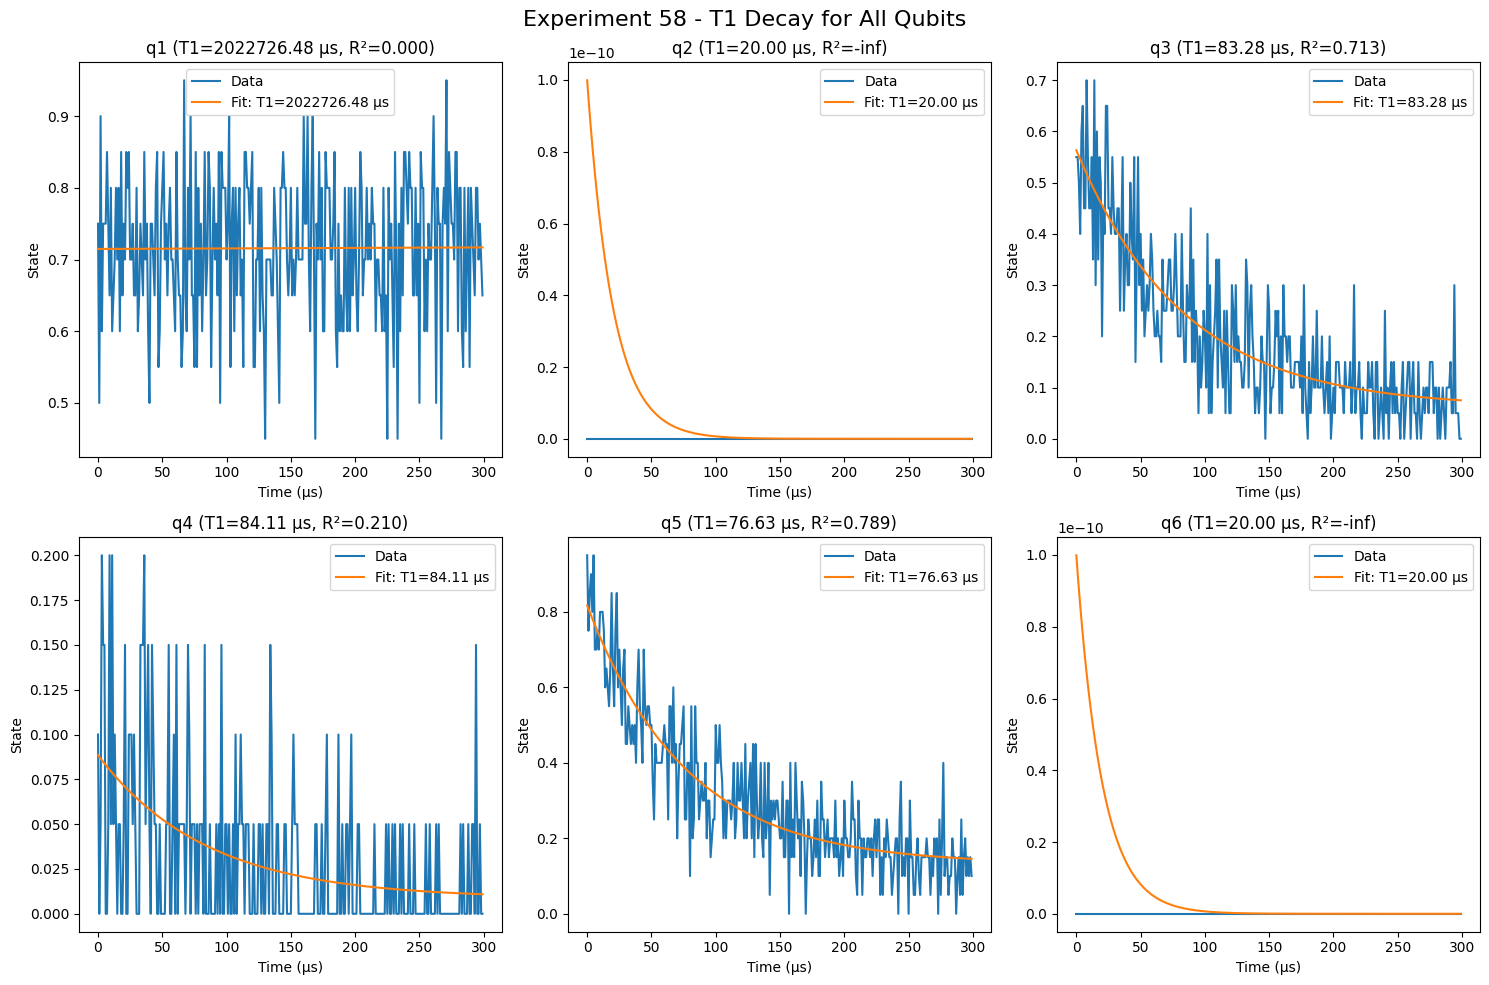



Exp 70 - q1: T1 = 3365354.84 µs (R² = 0.0263)
Exp 70 - q2: T1 = 112.64 µs (R² = 0.9941)
Exp 70 - q3: T1 = 106.18 µs (R² = 0.9932)
Exp 70 - q4: T1 = 107.62 µs (R² = 0.9621)
Exp 70 - q5: T1 = 68.63 µs (R² = 0.9922)
Exp 70 - q6: T1 = 112.61 µs (R² = 0.9937)


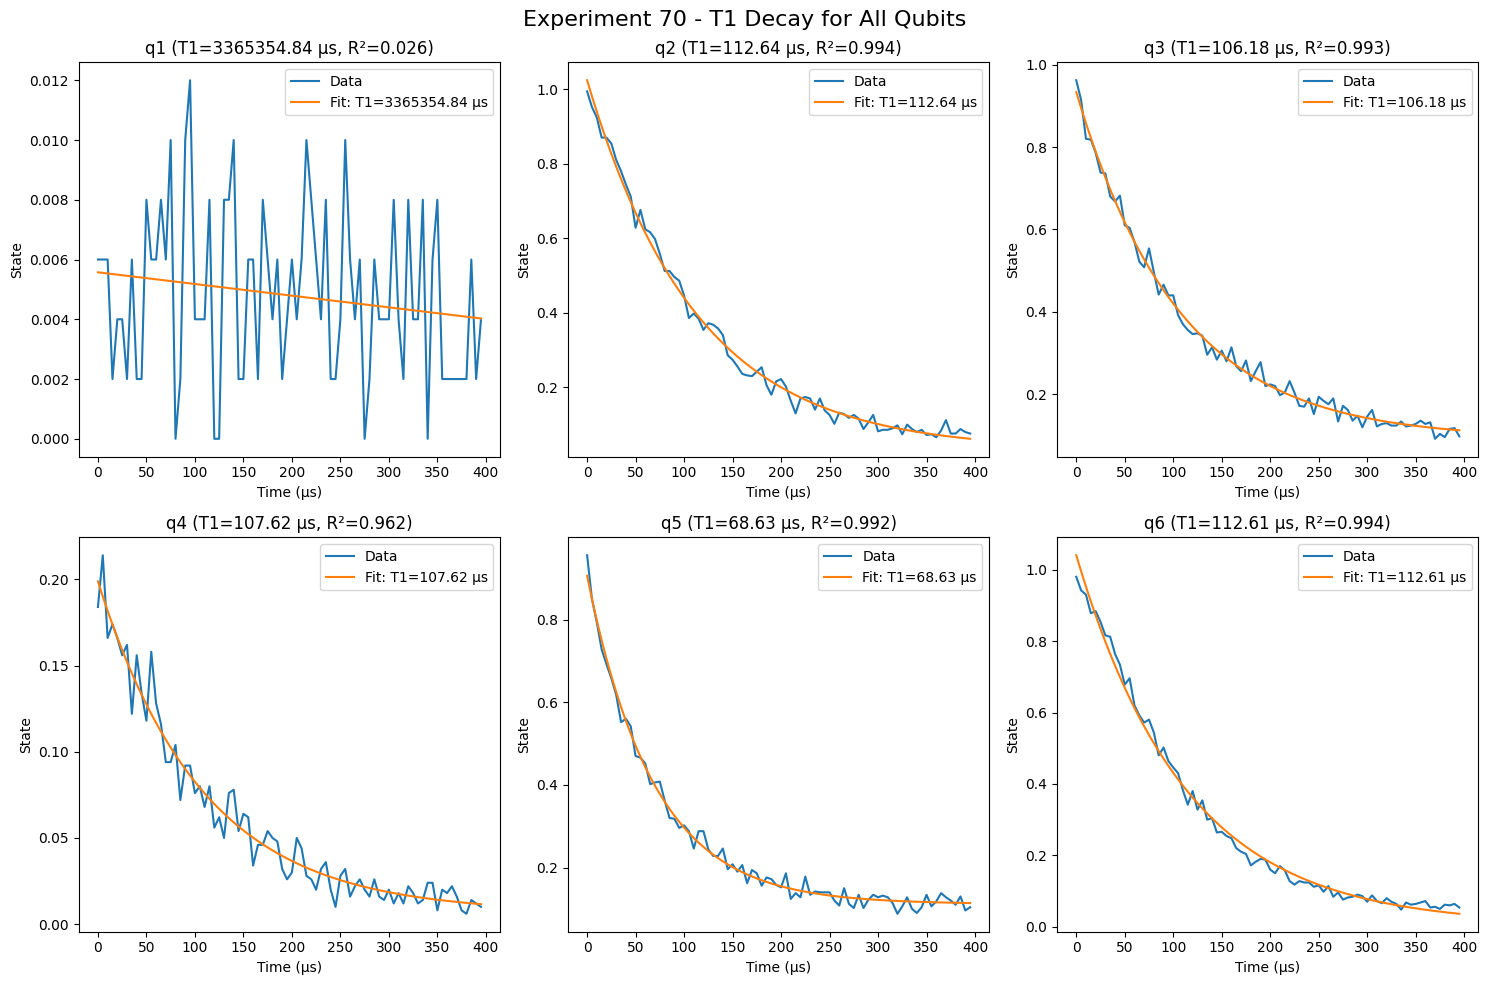



Best performing qubit: Exp70_q2 with T1 = 112.64 µs (R² = 0.9941)


In [9]:
# Load datasets
ds_58 = load_dataset(58)
ds_70 = load_dataset(70)

# Define exponential decay function
def exp_decay(t, A, T1, offset):
    """Exponential decay: A * exp(-t/T1) + offset"""
    return A * np.exp(-t / T1) + offset

# Store T1 results
t1_results = {}

# Analyze both experiments
for exp_num, ds in [(58, ds_58), (70, ds_70)]:
    qubits = ds[0].qubit.values
    times = np.asarray(ds[0]["idle_time"].values)
    
    # Create subplot grid (2 rows x 3 columns for 6 qubits)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Precompute fit grid once per experiment
    t_fit_grid = np.linspace(times.min(), times.max(), 200)
    
    for idx, qubit in enumerate(qubits):
        # Get state population data
        state = np.asarray(ds[0]['state'].values[idx])
        
        try:
            # Special handling for q2 and q6 in dataset 58
            if exp_num == 58 and qubit in ['q2', 'q6']:
                # Use better initial guess and bounds for problematic qubits
                p0 = [state[0] - state[-1], 20.0, state[-1]]
                bounds = ([0, 1, -0.5], [2, 200, 1.5])
                popt, pcov = curve_fit(exp_decay, times, state, p0=p0, bounds=bounds, maxfev=10000)
            else:
                # Standard fitting
                p0 = [1.0, np.mean(times), 0.0]
                popt, pcov = curve_fit(exp_decay, times, state, p0=p0, maxfev=10000)
            
            A_fit, T1_fit, offset_fit = popt
            
            # Calculate R-squared
            residuals = state - exp_decay(times, *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((state - np.mean(state))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            # Plot data (continuous line) and fit
            axes[idx].plot(times, state, '-', linewidth=1.5, label='Data')
            axes[idx].plot(t_fit_grid, exp_decay(t_fit_grid, *popt), '-', label=f"Fit: T1={T1_fit:.2f} µs")
            axes[idx].set_xlabel("Time (µs)")
            axes[idx].set_ylabel("State")
            axes[idx].set_title(f'{qubit} (T1={T1_fit:.2f} µs, R²={r_squared:.3f})')
            axes[idx].legend()
            
            # Print results
            print(f"Exp {exp_num} - {qubit}: T1 = {T1_fit:.2f} µs (R² = {r_squared:.4f})")
            
            # Store results
            t1_results[f'Exp{exp_num}_{qubit}'] = {'T1': T1_fit, 'R2': r_squared}
            
        except Exception as e:
            axes[idx].plot(times, state, '-', linewidth=1.5)
            axes[idx].set_xlabel("Time (µs)")
            axes[idx].set_ylabel("State")
            axes[idx].set_title(f'{qubit} (Fit failed)')
            print(f"Exp {exp_num} - {qubit}: Fit failed - {e}")
    
    plt.suptitle(f'Experiment {exp_num} - T1 Decay for All Qubits', fontsize=16)
    plt.tight_layout()
    plt.show()
    print("\n")

# Find best qubit (longest T1)
valid_results = {k: v for k, v in t1_results.items() if v['R2'] > 0.5}
if valid_results:
    best = max(valid_results.items(), key=lambda x: x[1]['T1'])
    print(f"{'='*50}\nBest performing qubit: {best[0]} with T1 = {best[1]['T1']:.2f} µs (R² = {best[1]['R2']:.4f})")

## Problem #4
Between the experiments run on 2025/10/13 and 2025/10/14, there was a large change in performance. This can be attributed to
the tune-up of the qubits between 10-13 and 10-14. All of the attributes that go into this are in the state.json file. Compare the data/2025-10-13/#58_05_T1_160134/quam_state/state.json and data/2025-10-14/#70_05_T1_091936/quam_state/state.json files. What are the most significant changes between the two? How, in terms of Hamiltonians, resonators, input/output theory, IQ Blobs, or any other concept we have learned, would that have had an impact?


First of all, it is important to notice that the .json files are the calibration parameters for the machine to run experiments and I would like to highlight that by comparing both files we can notice that only qubits 1 and 3 count with the implemented step_response_model_parameters while the rest of qubits don’t, this means that qubits 1 and 3 are calibrated for high-speed-Z pulses and the flux lines of the qubits 2,4,5, and 6 are calibrated for simple direct current flux biasing ignoring the high-fidelity fast-Z operations.
Now, comparing qubit per qubit calibration, we can see that for qubit 1 the data is the same, including frequency, flux, current, voltage, T1, and T2, which means that the calibration was the same for both experiments but it is not really important since the qubit wasn’t working properly to perform measurements, which can be notice from the confusion matrix.
For qubit 2, we can see that the parameters are pretty similar but not equal on both experiments but in this case the confusion matrices reflect a high fidelity, which indicates that qubit was working fine at the moment of calibration for both experiments, but we can see from the result of experiment 58 that the qubit’s frequency drifted significantly, thus the pi-pulse was no longer on resonance with the qubit, which is pretty different compared to the result ran in experiment 70.
Qubit 3 also shows similar values on both experiments for the next parameters: frequency vs flux ratios, intermediate frequence, current, voltage, T1, and T2 times. The confusion matrix for this qubit reflects a good fidelity for both experiments meaning that the calibration was carried out properly, but once again from experiment 58 we can see that the qubit was measurement presented significant noise, while in experiment 70 it presents less noise.
Now, for qubits 4 and 5 it is important to highlight the parameter value of the dispersive shift, “chi”, since it is different for qubits 4 and 5 when they were calibrated for each experiment and its change causes the qubit to have a different readout resonator. In general, for qubit 4 we can say that the parameter values are pretty similar for experiments 58 and 70 except for the dispersive shift. On the other hand, qubit 5 seems to have similar parameter values but the intermediate frequency is considerably different, and the result of this is the shift on the chi parameter.
Finally, for qubit 6, we can arrive to a similar conclusion to that of qubit 2 by observing the results of both experiments, the qubit was calibrated correctly before both experiments but on experiment 58 the qubit’s frequency changed significantly, and the pi-pulse was no longer on resonance with qubit 6.
To perform a deeper analysis, let’s focus on qubit 5 since it had the biggest recalibration from experiment 58 to experiment 70 and as a consequence it had a frequency shift close to 300 MHz. This change in the tune-up of the qubit increased its readout fidelity by moving it further away from its readout resonator, which reduced measurement-induced errors.
Recall that the qubit’s frequency is set by applying a static magnetic flux, and the change of the magnetic flux is also seen reflected as a change in the Hamiltonian since the Hamiltonian depends on the magnetic flux and the entire flux-to-frequency model is being recalibrated by this change.
Is also important to notice that moving the qubit further from the resonator reduces the Purcell effect, this occurs when the qubit rapidly decays by emitting its energy into the resonator, as well as avoiding off-resonant effects from the strong microwave pulse used for readout. Subsequently, by moving the qubit away from the resonator it is being pushed into the dispersive regime, where we know that the detuning is way larger than the coupling g.
